In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import seaborn as sb
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D,AveragePooling2D
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
CNN_model_age_recognition.ipynb

In [2]:
images = []
ages = []

def class_labels_reassign(given_age):
    if 1 <= given_age <= 9:
        return 0
    elif 10 <= given_age <= 15:
        return 1
    elif 16 <= given_age <= 20:
        return 2
    elif 21 <= given_age <= 27:
        return 3
    elif 28 <= given_age <= 34:
        return 4
    elif 35 <= given_age <= 46:
        return 5
    elif 47 <= given_age <= 65:
        return 6
    else:
        return 7
    
def preprocessing(given_img):
    given_img = cv2.cvtColor(given_img, cv2.COLOR_BGR2GRAY)  # converting image to grayscale.
    given_img = cv2.equalizeHist(given_img)
    given_img = given_img / 255  # normalizing image.
    given_img = cv2.resize(given_img, (64, 64))  # resizing it.
    return given_img

## Training the model

In [3]:
# Please provide your own image path
path = "C:/Users/mrsal/Github Repositories/Dataset/Age Recognition/unified"

for image in os.listdir(path):
    img = cv2.imread(path + "/" + image)
    images.append(img)
    ages.append(class_labels_reassign(float(image.split("_")[0])))

X_train, X_valid, y_train, y_valid = train_test_split(images, ages, test_size=0.33, random_state=42)

ImagesTrainingAfterPreProcessing = []
ImagesValidationAfterPreProcessing = []

In [4]:
for x in X_train:
    ImagesTrainingAfterPreProcessing.append(preprocessing(x))
for x in X_valid:
    ImagesValidationAfterPreProcessing.append(preprocessing(x))
y_train = np.array(y_train)
y_valid = np.array(y_valid)
ImagesTrainingAfterPreProcessing = np.array(ImagesTrainingAfterPreProcessing)
ImagesValidationAfterPreProcessing = np.array(ImagesValidationAfterPreProcessing)
y_validBeforeCategorical = y_valid
y_train = to_categorical(y_train, 8)
y_valid = to_categorical(y_valid, 8)

In [5]:
ImagesTrainingAfterPreProcessing = ImagesTrainingAfterPreProcessing.reshape(ImagesTrainingAfterPreProcessing.shape[0],
                                                                            ImagesTrainingAfterPreProcessing.shape[1],
                                                                            ImagesTrainingAfterPreProcessing.shape[2],
                                                                            1)
ImagesValidationAfterPreProcessing = ImagesValidationAfterPreProcessing.reshape(
    ImagesValidationAfterPreProcessing.shape[0], ImagesValidationAfterPreProcessing.shape[1],
    ImagesValidationAfterPreProcessing.shape[2], 1)

stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [6]:
model = Sequential()
model.add(
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.5))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 average_pooling2d (AverageP  (None, 29, 29, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 13, 128)      0         
 ePooling2D)                                            

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
tensorboard = TensorBoard(log_dir="./cnn_logs")
checkpoint = ModelCheckpoint(filepath = f"./cnn_logs/age_model_checkpoint.h5",
                             monitor = 'val_acc',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [8]:
history = model.fit(ImagesTrainingAfterPreProcessing, 
                    y_train,
                    validation_data=(ImagesValidationAfterPreProcessing, y_valid),
                    batch_size=128,
                    callbacks=[tensorboard, checkpoint],
                    epochs=64,
                    verbose=1)
model.save("./CNN_MODEL_64.h5")

Epoch 1/64
345/345 [==============================] - ETA: 0s - loss: 1.8608 - acc: 0.2745
Epoch 1: val_acc improved from -inf to 0.41107, saving model to ./cnn_logs\age_model_checkpoint.h5
345/345 [==============================] - 75s 78ms/step - loss: 1.8608 - acc: 0.2745 - val_loss: 1.4831 - val_acc: 0.4111
Epoch 2/64
344/345 [============================>.] - ETA: 0s - loss: 1.4717 - acc: 0.4235
Epoch 2: val_acc improved from 0.41107 to 0.47099, saving model to ./cnn_logs\age_model_checkpoint.h5
345/345 [==============================] - 25s 72ms/step - loss: 1.4716 - acc: 0.4235 - val_loss: 1.2991 - val_acc: 0.4710
Epoch 3/64
344/345 [============================>.] - ETA: 0s - loss: 1.3162 - acc: 0.4717
Epoch 3: val_acc improved from 0.47099 to 0.47979, saving model to ./cnn_logs\age_model_checkpoint.h5
345/345 [==============================] - 25s 72ms/step - loss: 1.3163 - acc: 0.4717 - val_loss: 1.2519 - val_acc: 0.4798
Epoch 4/64
344/345 [============================>.] - E

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 average_pooling2d (AverageP  (None, 29, 29, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 29, 29, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 average_pooling2d_1 (Averag  (None, 13, 13, 128)      0         
 ePooling2D)                                            

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

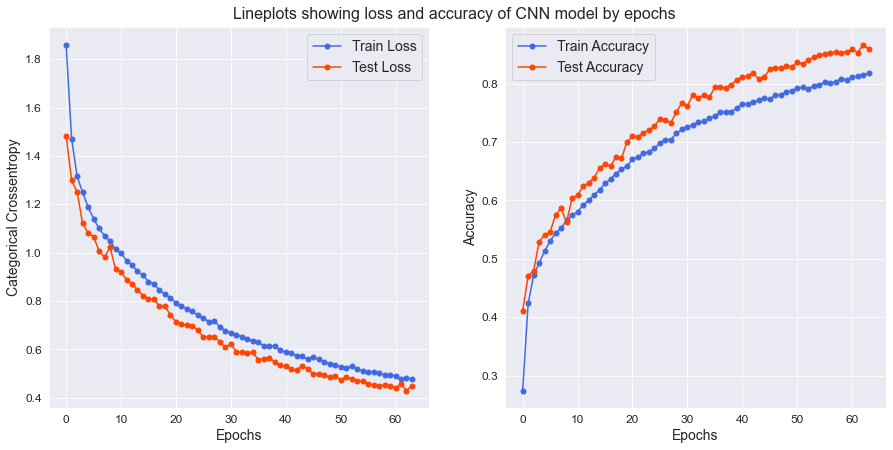

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(history.history['loss'], label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(history.history['val_loss'], label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(history.history['acc'], label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(history.history['val_acc'], label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

### Loading model and evaluation

In [3]:
# This code is in order to load the model. Make sure location and naming of a model is same, otherwise, please change below
model = tf.keras.models.load_model("./CNN_MODEL_64.h5")

In [4]:
# Here you can change parameter of age. Make sure the number of digits is 3. There are folders
# like 001 002 015 054 which define the age of the person 

age = '0' + '32'
testPath = "C:/Users/mrsal/Downloads/facial-age/" + age
images = []
ages=[]
i=0
for image in os.listdir(testPath):
    img = cv2.imread(testPath + "/" + image)
    images.append(img)
    ages.append(class_labels_reassign(float(32)))
    i = i + 1
X_valid = images
y_valid = ages
# rename to images
Image = []
for x in X_valid:
    Image.append(preprocessing(x))
y_valid = np.array(y_valid)
Image = np.array(Image)
y_validBeforeCategorical = y_valid

y_valid = to_categorical(y_valid, 8)

Image = Image.reshape(
    Image.shape[0], Image.shape[1],
    Image.shape[2], 1)
predictions = model.predict(Image)
result = []

for i in range(0, len(y_valid)):
    result.append(np.argmax(predictions[i]))

resultArray = np.array(result)
resultArray.reshape((1, resultArray.shape[0]))
resultArray
hotNCold = tf.math.confusion_matrix(y_validBeforeCategorical, resultArray)
print(hotNCold)


5/5 [==============================] - 7s 44ms/step
tf.Tensor(
[[  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]
 [  0   0   1   8 124   8]
 [  0   0   0   0   0   0]], shape=(6, 6), dtype=int32)


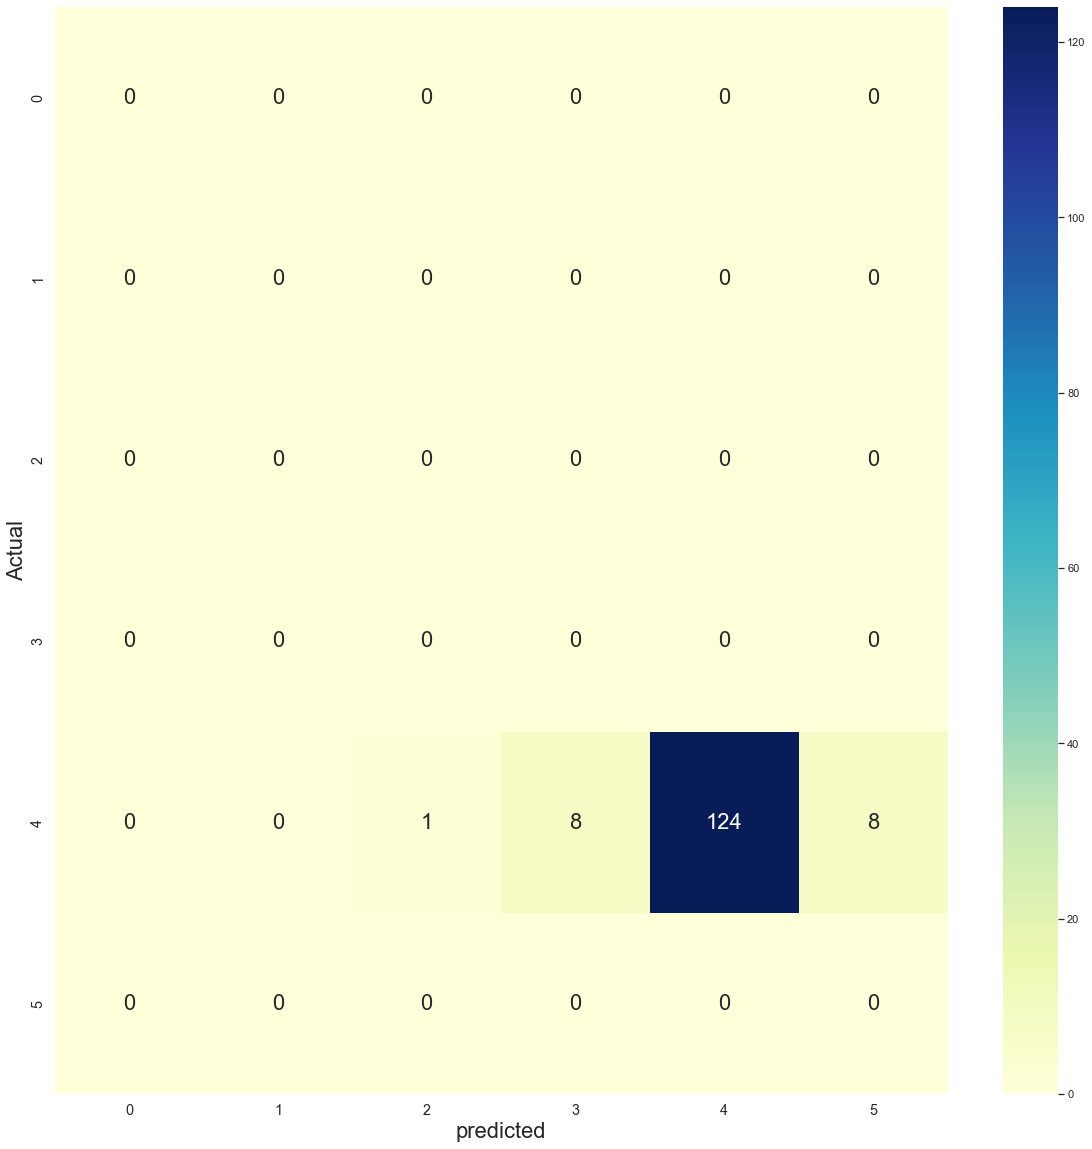

In [5]:
plt.figure(figsize=(20, 20))
sb.set()
heatMap = sb.heatmap(hotNCold, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 22})
heatMap.tick_params(axis='both', labelsize='large')
plt.xlabel("predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.show()

In [6]:
age_groups = ['032', '056', '001', '025', '013', '018', '039', '070'] # list of all age groups you want to perform prediction on
images = []
ages = []
for age in age_groups:
    testPath = "C:/Users/mrsal/Downloads/facial-age/" + age
    for image in os.listdir(testPath):
        img = cv2.imread(testPath + "/" + image)
        images.append(img)
        ages.append(class_labels_reassign(float(int(age))))

X_valid = images
y_valid = ages
# rename to images
Image = [preprocessing(x) for x in X_valid]
y_valid = np.array(y_valid)
Image = np.array(Image)
y_validBeforeCategorical = y_valid
y_valid = to_categorical(y_valid, 8)
Image = Image.reshape(
    Image.shape[0], Image.shape[1],
    Image.shape[2], 1)
predictions = model.predict(Image)
result = [np.argmax(prediction) for prediction in predictions]
resultArray = np.array(result)
resultArray.reshape((1, resultArray.shape[0]))
resultArray
hotNCold = tf.math.confusion_matrix(y_validBeforeCategorical, resultArray)
print(hotNCold)

63/63 [==============================] - 1s 10ms/step
tf.Tensor(
[[1112    0    0    0    0    0    0    0]
 [   3   71    0    0    0    1    0    0]
 [   0    2  177    2    0    0    0    0]
 [   0    0    1  149    4    2    0    0]
 [   0    0    1    8  124    8    0    0]
 [   0    0    0    0    6  123    7    0]
 [   0    0    0    1    0    2  128    1]
 [   0    0    0    0    0    0    1   52]], shape=(8, 8), dtype=int32)


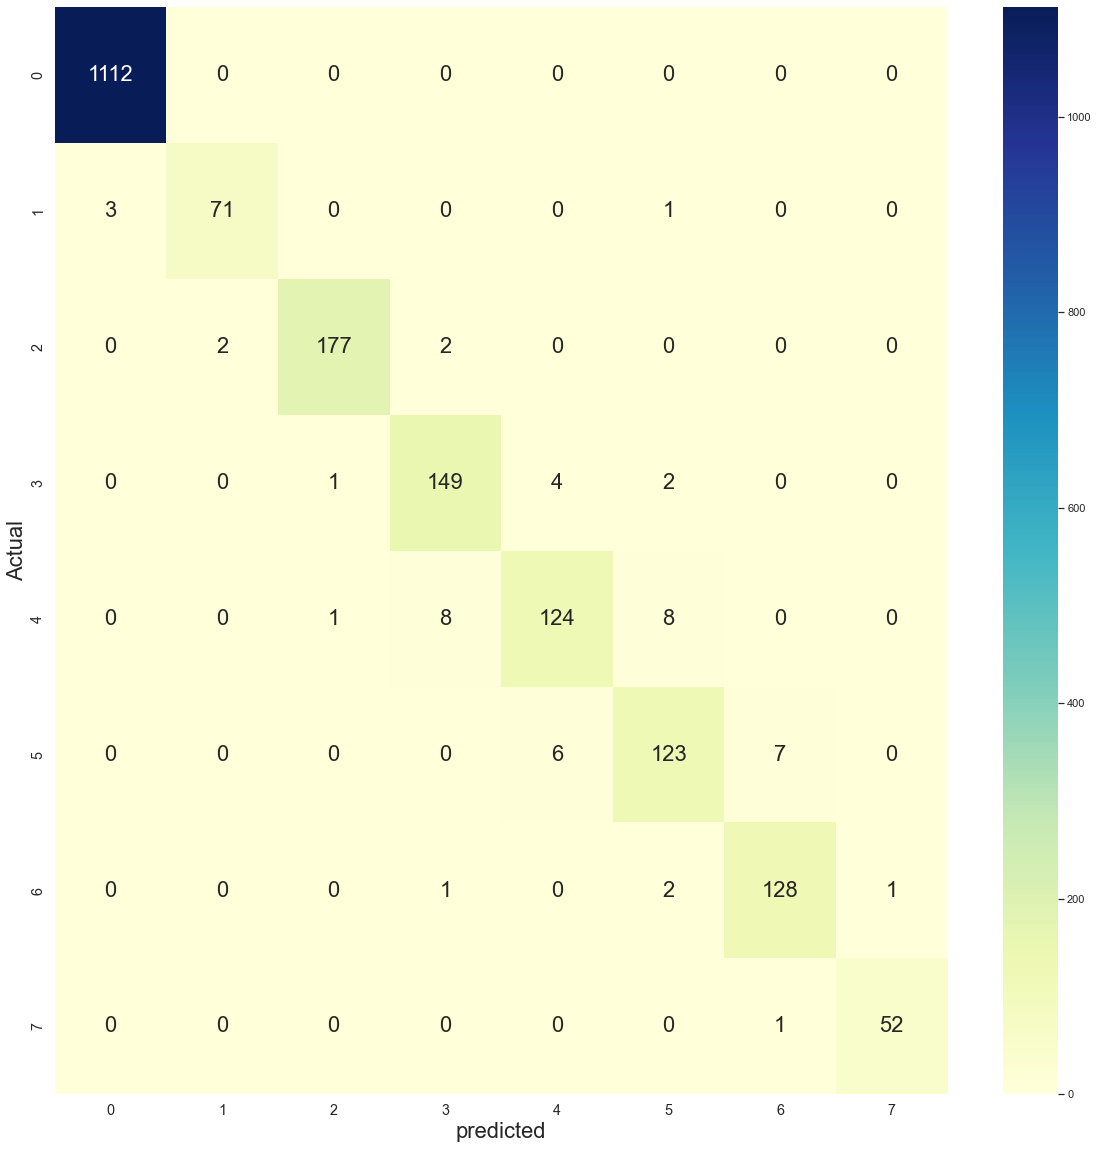

In [20]:
plt.figure(figsize=(20, 20))
sb.set()
heatMap = sb.heatmap(hotNCold, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"size": 22})
heatMap.tick_params(axis='both', labelsize='large')
plt.xlabel("predicted", fontsize=22)
plt.ylabel("Actual", fontsize=22)
plt.show()